In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

df1 = pd.read_csv('tr_basic_cardl_20210101_20230630.csv') #롯데카드
df2 = pd.read_csv('tr_basic_cardh_20190101_20230630.csv') #하나카드
df3 = pd.read_csv('LIST_BT.csv') #종목코드

lottecard = df1[df1['mandata_brand_name'].isin(['LOTTE SHOPPING CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
hanacard = df2[df2['mandata_brand_name'].isin(['LOTTE SHOPPING CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
card_data = pd.merge(lottecard, hanacard, on=['transaction_date', 'mandata_brand_name'], how='outer')
card_data.to_csv('card_data_(shinsegae,lotte).csv', index=False)

In [2]:
data = pd.read_csv('card_data_(shinsegae,lotte).csv', parse_dates=['transaction_date'])
data['mon'] = data['transaction_date'].dt.month
data['year'] = data['transaction_date'].dt.year
monthly_data = data.groupby(['mandata_brand_name', 'year', 'mon']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
yearly_data = data.groupby(['mandata_brand_name', 'year']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
# monthly_data['sales_all_month'] = monthly_data['sales_l'] + monthly_data['sales_h']
monthly_data['sales_all_month'] = monthly_data['sales_h']
# yearly_data['sales_all_year'] = yearly_data['sales_l'] + yearly_data['sales_h']
yearly_data['sales_all_year'] = yearly_data['sales_h']
monthly_data = pd.merge(monthly_data, yearly_data[['mandata_brand_name', 'year', 'sales_all_year']], on=['mandata_brand_name', 'year'], how='left', suffixes=('', '_right'))

monthly_data.to_csv('sales_data_(shinsegae,lotte).csv', index=False)

In [3]:
l_close = pd.read_csv('l_close.csv', parse_dates=['transaction_date'])
s_close = pd.read_csv('s_close.csv', parse_dates=['transaction_date'])
close_ls = pd.merge(l_close, s_close[['transaction_date', 'Close']], on='transaction_date', how='left', suffixes=('_l', '_s'))
close_ls.to_csv('stock_data_(shinsegae,lotte).csv', index=False)

In [4]:
df = pd.read_csv('sales_data_(shinsegae,lotte)2.csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] 

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

for i in range(len(monthly_ratio)):
    year = monthly_ratio.loc[i, 'year']
    mon = monthly_ratio.loc[i, 'mon']
    name = monthly_ratio.loc[i, 'mandata_brand_name']
    
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values

    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'buy'
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'sell'
        else:
            monthly_ratio.loc[i, 'active'] = 'hold'
    else:
        monthly_ratio.loc[i, 'active'] = 'no data'

monthly_ratio.to_csv('monthly_active_(shinsegae,lotte).csv', index=False)

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
changed_rows = changed_rows.drop(columns=['_merge'])

changed_rows.to_csv('table_(shinsegae,lotte).csv', index=True)

In [8]:
close_ls = pd.read_csv('stock_data_(shinsegae,lotte).csv', index_col='transaction_date', parse_dates=True)

start_date = '2019-01-31'
end_date ='2023-07-31'

sell_l = close_ls.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_s_return'] = sell_l['Close_s'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_s_return'] = sell_l['close_s_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_s_return'] = (1 + sell_l['close_s_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_s_return'] + sell_l['l_return_sell'] 
sell_l.to_csv('close_ls.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("신세계 롱 누적수익률:", sell_l['cumulative_s_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)
return1 = sell_l['return'].iloc[-1]  # 매매 누적수익률

롯데쇼핑 숏 누적수익률: 64.2857142857143
신세계 롱 누적수익률: -27.712665406427362
매매 누적수익률: 36.573048879286944


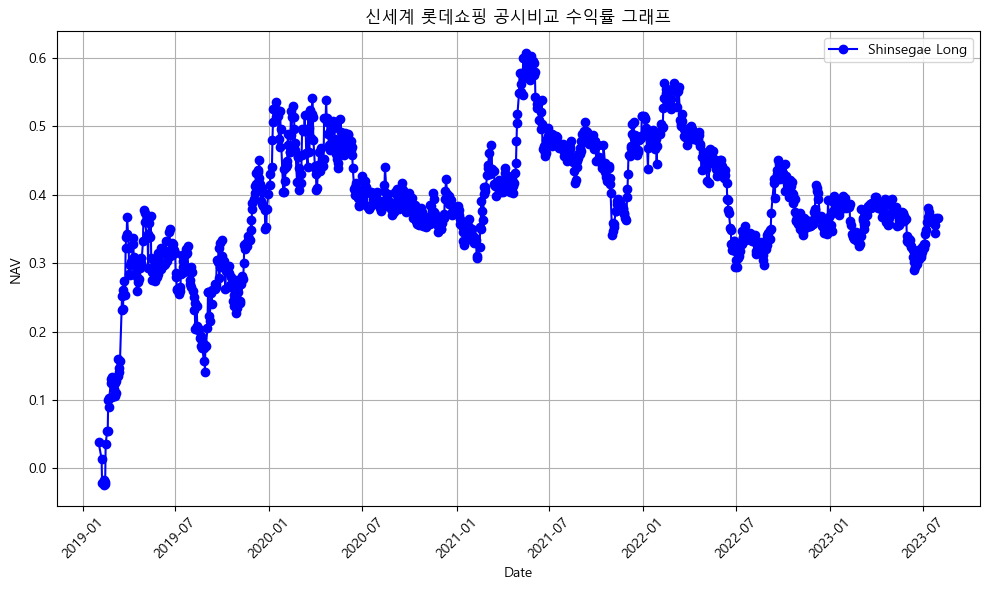

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정\

# 데이터 불러오기
df = pd.read_csv('close_ls.csv')

# 결측치 제거
df = df.dropna()

# 날짜 데이터를 datetime으로 변환
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['type'] = 'shinsegae_long'

# 'type' 열을 사용하여 데이터 필터링
shinsegae_long = df[df['type'] == 'shinsegae_long']

# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(shinsegae_long['transaction_date'], shinsegae_long['return'], marker='o', color='blue', label='Shinsegae Long')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('신세계 롯데쇼핑 공시비교 수익률 그래프')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정\

# 데이터 불러오기
df = pd.read_csv('close_ls.csv')

# 결측치 제거
df = df.dropna()

# 날짜 데이터를 datetime으로 변환
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['type'] = 'hyundai_long'
df

,transaction_date,Close_l,Close_s,close_s_return,close_l_return,cumulative_s_return,cumulative_l_return,l_return_sell,return,type
1,2019-02-01,194000,272000,0.028355,-0.010204,0.028355,-0.010204,0.010204,0.038559,hyundai_long
2,2019-02-07,194000,265500,-0.023897,0.000000,0.003781,-0.010204,0.010204,0.013985,hyundai_long
3,2019-02-08,194500,257000,-0.032015,0.002577,-0.028355,-0.007653,0.007653,-0.020702,hyundai_long
4,2019-02-11,191000,251500,-0.021401,-0.017995,-0.049149,-0.025510,0.025510,-0.023639,hyundai_long
5,2019-02-12,193500,256500,0.019881,0.013089,-0.030246,-0.012755,0.012755,-0.017491,hyundai_long
...,...,...,...,...,...,...,...,...,...,...
1106,2023-07-25,69300,187600,-0.013151,-0.005739,-0.290737,-0.646429,0.646429,0.355691,hyundai_long
1107,2023-07-26,67500,182100,-0.029318,-0.025974,-0.311531,-0.655612,0.655612,0.344081,hyundai_long
1108,2023-07-27,70400,191800,0.053267,0.042963,-0.274858,-0.640816,0.640816,0.365958,hyundai_long
1109,2023-07-28,69200,189600,-0.011470,-0.017045,-0.283176,-0.646939,0.646939,0.363763,hyundai_long


참고들

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

In [ ]:
close_dm = pd.read_csv('card_data_(daesung,mega).csv', parse_dates=['transaction_date'])
close_dm = close_dm[['transaction_date', 'mandata_brand_name']]
m_df = close_dm[close_dm['mandata_brand_name'] == 'MEGASTUDYCO LTD_ALL']
d_df = close_dm[close_dm['mandata_brand_name'] == 'DIGITAL DAESUNG CO LTD_ALL']

m_df = m_df.sort_values(by='transaction_date')
d_df = d_df.sort_values(by='transaction_date')

next_month_date = m_df['transaction_date'].iloc[-1] + pd.offsets.MonthBegin(1)

new_data = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['MEGASTUDYCO LTD_ALL'] * 31
}
new_data2 = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['DIGITAL DAESUNG CO LTD_ALL'] * 31
}

new_rows_df = pd.DataFrame(new_data)
new_rows_df2 = pd.DataFrame(new_data2)
m_df = pd.concat([m_df, new_rows_df], ignore_index=True)
d_df = pd.concat([d_df, new_rows_df2], ignore_index=True)

In [ ]:
m_close = fdr.DataReader('072870', '2021-02-01', '2023-07-31') 
m_close = m_close[['Close']]
d_close = fdr.DataReader('068930', '2021-02-01', '2023-07-31') 
d_close = d_close[['Close']]
m_close.to_csv('m_close.csv', index=True)
d_close.to_csv('d_close.csv', index=True)

h_close = fdr.DataReader('069960', '2019-01-31', '2023-07-31') 
h_close = h_close[['Close']]
l_close = fdr.DataReader('023530', '2019-01-31', '2023-07-31') 
l_close = l_close[['Close']]
h_close.to_csv('h_close.csv', index=True)
l_close.to_csv('l_close.csv', index=True)

e_close = fdr.DataReader('139480', '2019-01-31', '2023-07-31') 
e_close = e_close[['Close']]
s_close = fdr.DataReader('004170', '2019-01-31', '2023-07-31') 
s_close = s_close[['Close']]
e_close.to_csv('e_close.csv', index=True)
s_close.to_csv('s_close.csv', index=True)